In [1]:
import pandas as pd

In [98]:
df = pd.read_excel('train_data_RFM.xlsx')

In [171]:
df1 = df.tail(500000)

# Recency 전처리

In [172]:
from datetime import datetime, timedelta

In [173]:
df1_Recency = df1.pivot_table(index = 'Customer_ID', values = 'Order_Date', aggfunc = 'max')

In [174]:
Recency = pd.DataFrame(df1_Recency['Order_Date'].apply(lambda x : pd.to_datetime('2020-10-01') - x).dt.days)
Recency

,Order_Date
Customer_ID,
100004,100
100006,170
100008,165
100010,16
100013,114
...,...
999979,140
999989,44
999993,15


In [175]:
Recency.rename(columns = {'Order_Date': 'Recency'}, inplace = True)

# Frequency 전처리

In [176]:
df1_Frequency = df1.pivot_table(index = ['Customer_ID', 'Order_Date'], values = 'Price', aggfunc = 'count')

In [177]:
df1_Frequency.rename(columns = {'Price' : 'Frequency'}, inplace = True)

In [178]:
Frequency = df1_Frequency.reset_index(level ='Order_Date', drop = True)
Frequency

,Frequency
Customer_ID,
100004,1
100006,1
100008,2
100010,3
100010,1
...,...
999993,2
999993,4
999993,1


# Monetary 전처리

In [179]:
Monetary = df1.pivot_table(index = 'Customer_ID', values = 'Price', aggfunc = 'sum')


In [180]:
Monetary.rename(columns = {'Price':'Monetary'}, inplace = True)

# RFM Score 계산

In [181]:
# R,F,M 병합
df_merged = pd.concat([ Recency, Frequency,Monetary], axis = 1 )
df_merged

,Recency,Frequency,Monetary
Customer_ID,,,
100004,100,1,8475
100006,170,1,36850
100008,165,2,63675
100010,16,3,344550
100010,16,1,344550
...,...,...,...
999993,15,2,736197
999993,15,4,736197
999993,15,1,736197


In [182]:
#R_Score 계산
df_merged['R_Score'] = pd.qcut(df_merged['Recency'], 5, labels=[5,4,3,2,1]) 

In [183]:
#F_Score 계산
df_merged['Frequency'].value_counts().head(20)

1     195591
2      65013
3      17014
4      11701
6       3725
5       2740
8       1222
7        769
9        445
10       416
12       376
11       128
15       101
16        97
14        79
18        59
20        40
13        32
24        28
21        26
Name: Frequency, dtype: int64

In [184]:
# Frequency value의 1,2,3 빈도가 높아 qcut 활용 불가 -> 1은 1점, 2는 2점, 3은 3점, 4는 4점, 5회 이상은 5점 부여
def f_score(x):
    if x >= 5 :
        return 5
    else :
        return x

In [185]:
df_merged['F_Score'] = df_merged['Frequency'].apply(f_score)

In [186]:
# M_Score 계산
df_merged['M_Score'] = pd.qcut(df_merged['Monetary'], 5, labels=[1,2,3,4,5]) 

In [187]:
# Sum Score 계산
df_merged['Sum_Score'] = df_merged['R_Score'].astype(int) + df_merged['F_Score'].astype(int) + df_merged['M_Score'].astype(int)

In [188]:
df_merged

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Sum_Score
Customer_ID,,,,,,,
100004,100,1,8475,1,1,1,3
100006,170,1,36850,1,1,1,3
100008,165,2,63675,1,2,2,5
100010,16,3,344550,4,3,4,11
100010,16,1,344550,4,1,4,9
...,...,...,...,...,...,...,...
999993,15,2,736197,4,2,5,11
999993,15,4,736197,4,4,5,13
999993,15,1,736197,4,1,5,10


In [189]:
# 2차원 그래프 생성 위한 F-M 병합
df_merged['M_Score'] = df_merged['M_Score'].astype(int)
df_merged['FM_Avg'] = round((df_merged['F_Score'] + df_merged['M_Score'])/2)
df_merged['FM_Avg'] = df_merged['FM_Avg'].astype(int)

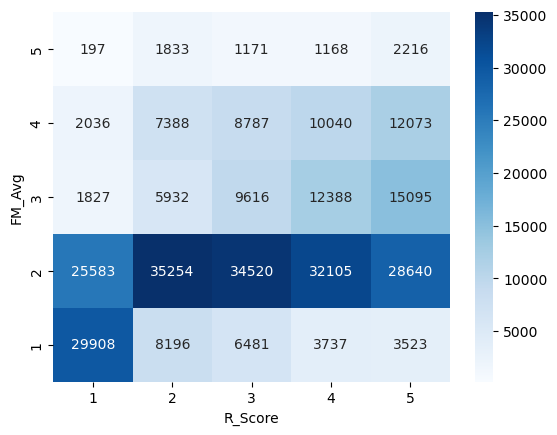

In [190]:
# Confusion Matrix 생성
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(df_merged['FM_Avg'], df_merged['R_Score'])
confusion_matrix = confusion_matrix.iloc[::-1, ::-1]

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt = 'd')
plt.xlabel('R_Score')
plt.ylabel('FM_Avg')
plt.show()
